In [7]:
import pandas as pd
import numpy as np

In [8]:
df_features = pd.read_csv('./data/customer_features_cleaned.csv')
df_features.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Year,Month,Day,Hour,Weekday,DateOnly,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,1,7,Tuesday,2009-12-01,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7,Tuesday,2009-12-01,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,7,Tuesday,2009-12-01,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,1,7,Tuesday,2009-12-01,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,1,7,Tuesday,2009-12-01,30.0


In [9]:
# 1. Snapshot date để tính Recency (1 ngày sau ngày cuối cùng)
df_features['InvoiceDate'] = pd.to_datetime(df_features['InvoiceDate'])
snapshot_date = df_features['InvoiceDate'].max() + pd.Timedelta(days=1)

# 2. Nhóm theo Customer ID
customer_df = df_features.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'Revenue': 'sum',                                         # Monetary
    'Invoice': 'count',                                       # Total Orders (tạm tính)
    'StockCode': 'nunique'                                    # UniqueProductCount
}).rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'Monetary',
    'StockCode': 'UniqueProductCount'
})

# 3. Tính AvgOrderValue
customer_df['AvgOrderValue'] = customer_df['Monetary'] / customer_df['Frequency']

# 4. Tính ReturnRate nếu có dữ liệu hoàn trả
df_features['IsReturn'] = df_features['Invoice'].astype(str).str.startswith('C')

# Tổng số đơn hàng trả lại và đơn hàng thường (không trùng nhau)
returns = df_features[df_features['IsReturn']].groupby('Customer ID')['Invoice'].nunique()
purchases = df_features[~df_features['IsReturn']].groupby('Customer ID')['Invoice'].nunique()

# Tỷ lệ hoàn trả = số đơn bị trả lại / tổng số đơn
return_rate = (returns / (returns + purchases)).fillna(0)
customer_df['ReturnRate'] = return_rate

# 5. Reset index (nếu cần) và lưu ra file
customer_df = customer_df.reset_index()



In [11]:
print("Top 5 khách chi tiêu nhiều nhất:")
display(customer_df.sort_values(by='Monetary', ascending=False).head())

# Top 5 khách hàng có tỷ lệ trả hàng cao
print("Top 5 khách có tỷ lệ hoàn trả cao:")
display(customer_df.sort_values(by='ReturnRate', ascending=False).head())

# Top 5 khách có Recency thấp nhất (mới mua gần đây)
print("Top 5 khách hàng mua gần nhất:")
display(customer_df.sort_values(by='Recency').head())

Top 5 khách chi tiêu nhiều nhất:


,Customer ID,Recency,Frequency,Monetary,UniqueProductCount,AvgOrderValue,ReturnRate,AvgInterpurchaseTime
5756,18102.0,1,1050,521434.03,384,496.603838,0.052288,0.667302
2300,14646.0,2,3890,504596.14,964,129.716231,0.073171,0.175109
1810,14156.0,10,4118,291802.55,1446,70.860260,0.227723,0.157153
2565,14911.0,1,11444,263699.15,2557,23.042568,0.219608,0.048414
1348,13694.0,4,1551,186151.64,902,120.020400,0.128049,0.438710


Top 5 khách có tỷ lệ hoàn trả cao:


,Customer ID,Recency,Frequency,Monetary,UniqueProductCount,AvgOrderValue,ReturnRate,AvgInterpurchaseTime
3772,16118.0,393,47,4255.43,42,90.541064,0.80,5.608696
3951,16297.0,213,23,275.40,21,11.973913,0.75,2.500000
1909,14255.0,546,4,-73.88,1,-18.470000,0.75,0.000000
1422,13768.0,564,43,758.07,37,17.629535,0.75,4.071429
1430,13776.0,428,8,-102.00,3,-12.750000,0.75,36.142857


Top 5 khách hàng mua gần nhất:


,Customer ID,Recency,Frequency,Monetary,UniqueProductCount,AvgOrderValue,ReturnRate,AvgInterpurchaseTime
923,13269.0,1,490,8507.01,239,17.361245,0.066667,1.488753
77,12423.0,1,166,2612.19,128,15.736084,0.090909,2.781818
87,12433.0,1,560,16757.20,286,29.923571,0.090909,0.844365
5144,17490.0,1,126,2585.06,94,20.516349,0.307692,4.512000
4212,16558.0,1,777,13149.56,383,16.923501,0.191489,0.920103


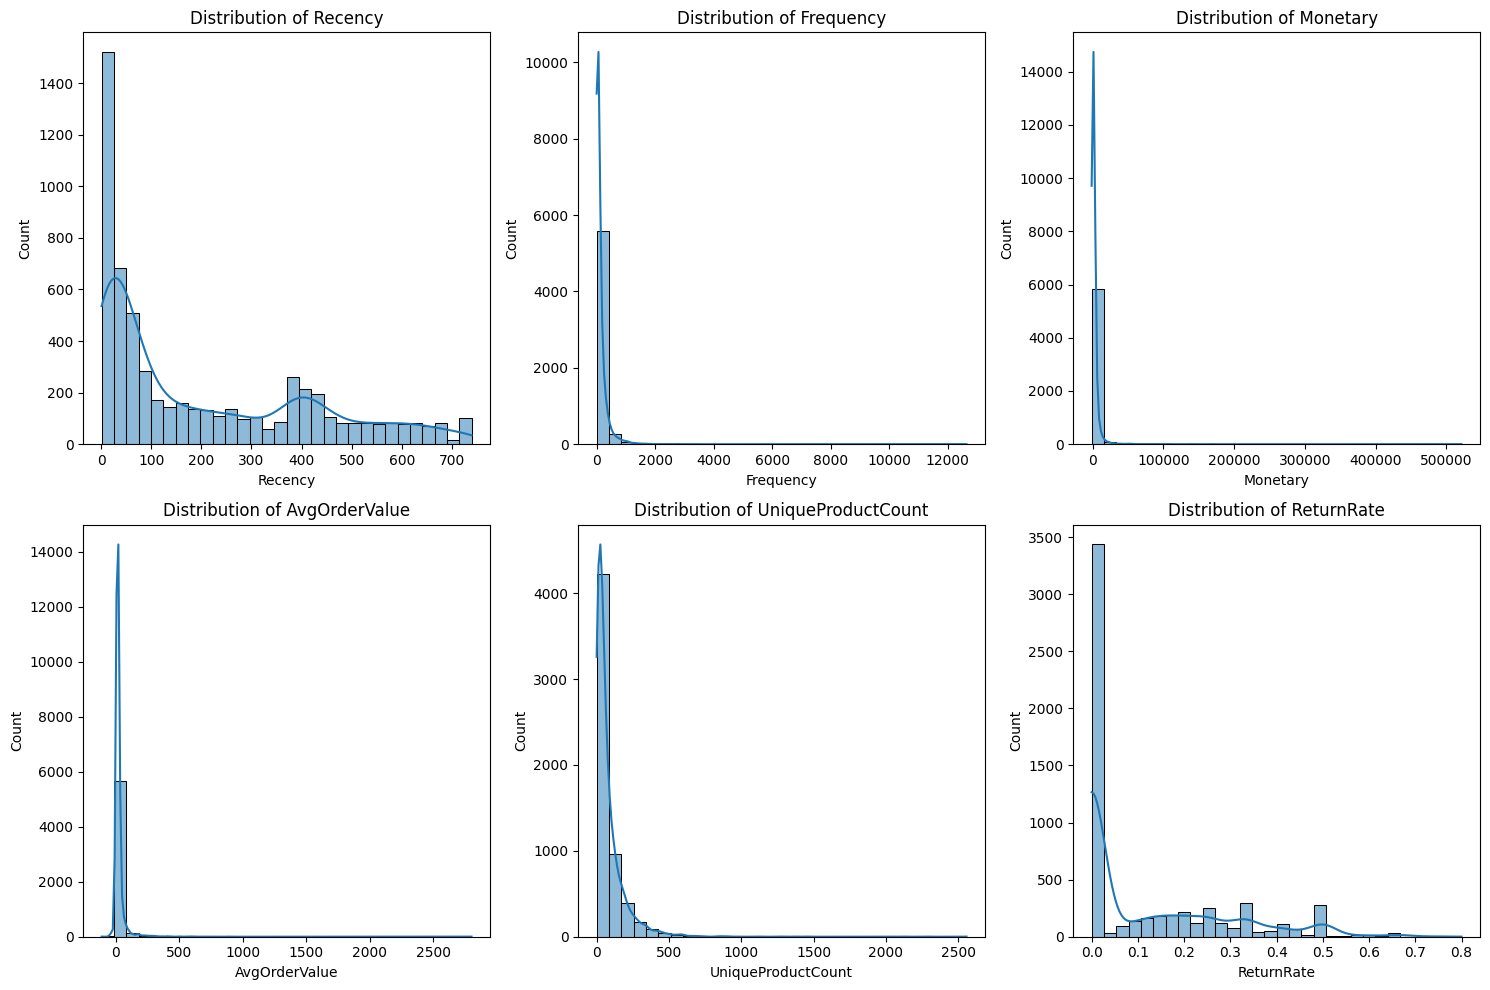

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

features_to_plot = ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'UniqueProductCount', 'ReturnRate']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.histplot(customer_df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

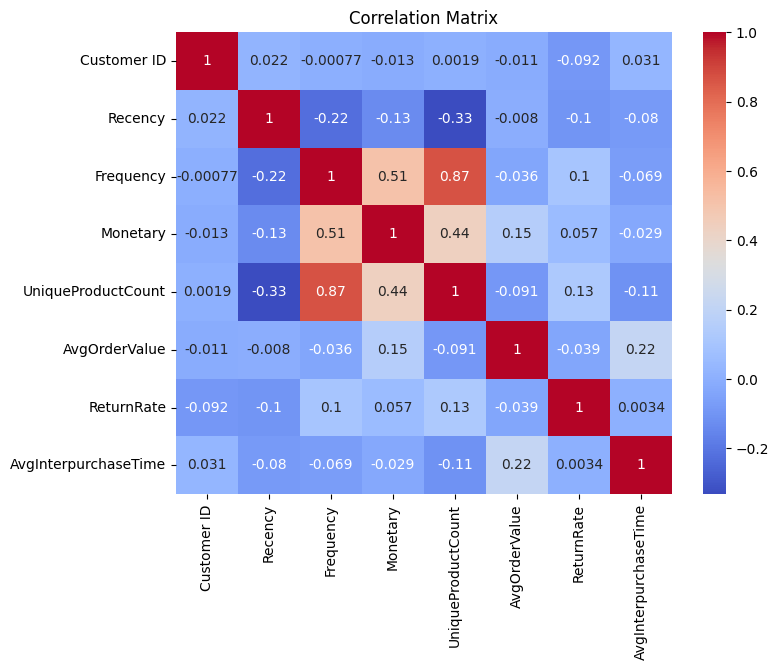

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(customer_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

                     Interpurchase-Time
Ứng dụng	                        Giải thích
Phân tích độ trung thành	        IPT thấp → khách mua thường xuyên → trung thành
Phân cụm khách hàng	                Có thể dùng để phân cụm khách hay quay lại và khách ngắt quãng
Dự đoán churn (rời bỏ)	            IPT tăng dần có thể là dấu hiệu sắp rời bỏ
Cá nhân hóa khuyến mãi	            Nếu biết IPT trung bình là 14 ngày → có thể gửi mã giảm giá trước ngày thứ 14

Công thức
T = L/(F-1) = (Tn - T1)/(F-1)

In [10]:
# Tính Interpurchase Time
df_sorted = df_features.sort_values(by=['Customer ID', 'InvoiceDate'])
df_sorted['InterpurchaseTime'] = df_sorted.groupby('Customer ID')['InvoiceDate'].diff().dt.days

# Trung bình Interpurchase Time theo khách
ipt = df_sorted.groupby('Customer ID')['InterpurchaseTime'].mean().fillna(0)
customer_df = customer_df.merge(ipt, on='Customer ID', how='left')
customer_df.rename(columns={'InterpurchaseTime': 'AvgInterpurchaseTime'}, inplace=True)


customer_df.to_csv('./data/customer_features_final.csv', index=False)


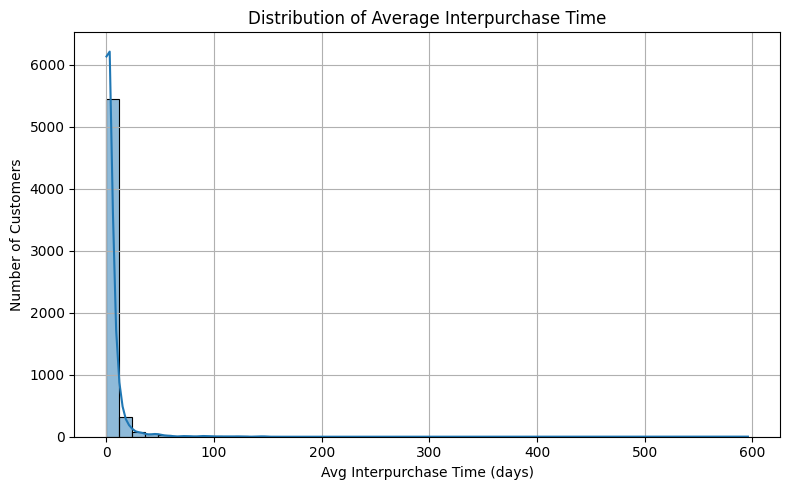

In [15]:
plt.figure(figsize=(8, 5))
sns.histplot(customer_df['AvgInterpurchaseTime'], bins=50, kde=True)
plt.title('Distribution of Average Interpurchase Time')
plt.xlabel('Avg Interpurchase Time (days)')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.tight_layout()
plt.show()

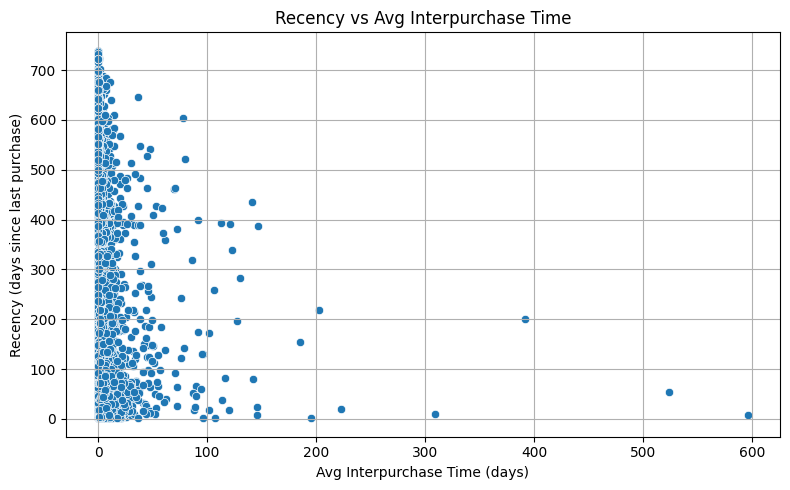

In [17]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=customer_df, x='AvgInterpurchaseTime', y='Recency')
plt.title('Recency vs Avg Interpurchase Time')
plt.xlabel('Avg Interpurchase Time (days)')
plt.ylabel('Recency (days since last purchase)')
plt.grid(True)
plt.tight_layout()
plt.show()

Scatter plot: Recency vs AvgInterpurchaseTime